# **Connect to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/Colab\ Notebooks/

/content/gdrive/My Drive/Colab Notebooks


# **Preprocessing the dataset**

- Load the data from Google Drive.
- In Google Drive, have 3 directories: train_data - valid_data - test_data.
- In each folder, data is stored in h5py format.
- Standardization (z-score).

In [3]:
import numpy as np
import h5py

In [4]:
def preprocessing_dataset(num_file, filename_prefix):
    X = []
    y = []

    # Load the data from h5py
    for i in range(1, num_file):
        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X.append(j)

            for j in f['y'][:]:
                y.append(j)

    # Convert to numpy array
    X = np.array(X)
    y = np.array(y)

    # Calculate the mean of each channel
    mean_0 = X[:, 0, :, :].mean()
    mean_1 = X[:, 1, :, :].mean()
    mean_2 = X[:, 2, :, :].mean()

    # Calculate the standard deviation of each channel
    std_0 = X[:, 0, :, :].std()
    std_1 = X[:, 1, :, :].std()
    std_2 = X[:, 2, :, :].std()

    # Standardization
    X[:, 0, :, :] = (X[:, 0, :, :] - mean_0) / std_0
    X[:, 1, :, :] = (X[:, 1, :, :] - mean_1) / std_1
    X[:, 2, :, :] = (X[:, 2, :, :] - mean_2) / std_2

    return X, y

**Configure the dataset**

In [5]:
train_num_file = 10
train_filename_prefix = 'train_data/X_train_'

valid_num_file = 4
valid_filename_prefix = 'valid_data/X_valid_'

test_num_file = 4
test_filename_prefix = 'test_data/X_test_'

### **Load the training set**

In [6]:
X_train, y_train = preprocessing_dataset(train_num_file, train_filename_prefix)

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...
Loading batch 4 ...
Loading batch 5 ...
Loading batch 6 ...
Loading batch 7 ...
Loading batch 8 ...
Loading batch 9 ...


In [7]:
print(X_train.shape)
print(y_train.shape)

(165133, 3, 50, 50)
(165133,)


### **Load the validation set**

In [8]:
X_valid, y_valid = preprocessing_dataset(valid_num_file, valid_filename_prefix)

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [9]:
print(X_valid.shape)
print(y_valid.shape)

(55044, 3, 50, 50)
(55044,)


### **Load the test set**

In [10]:
X_test, y_test = preprocessing_dataset(test_num_file, test_filename_prefix)

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [11]:
print(X_test.shape)
print(y_test.shape)

(55045, 3, 50, 50)
(55045,)


# **Building Model Convolution Neural Network**

In [12]:
import math
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
from torch import optim
from imblearn.over_sampling import SMOTE
import collections

from warnings import simplefilter, filterwarnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### **Parameters of the model**

In [13]:
EPOCHS = 80
BATCH_SIZE = 128
LR = 1e-6

### **Defining the Model**

**Model description:**

- Input model is RGB image data (3 color channels, 50 pixels height, 50 pixels width)
- Transform input image to multi-dimensional matrix with size 3 - 50 - 50.


**Activation function**

- The ReLU is the most used activation function in the world right now. Since, it is used in almost all the convolutional neural networks or deep learning. 
- Computationally efficient—allows the network to converge very quickly.
- Non-linear—although it looks like a linear function, ReLU has a derivative function and allows for backpropagation.

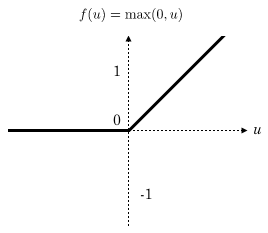

**Avoid overfitting**

To avoid overfitting in neural networks, use two methods of Dropout and Batch normalization.
- **Dropout**: is one of the most commonly used and the most powerful regularization techniques used in deep learning. Dropout is applied to intermediate layers of the model during the training time. Let's look at an example of how dropout is applied on a linear layer's output that generates 10 values:

  + The figure shows what happens when dropout is applied to the linear layer output with a threshold value of 0.2. It randomly masks or zeros 20% of data, so that the model will not be dependent on a particular set of weights or patterns, thus overfitting.

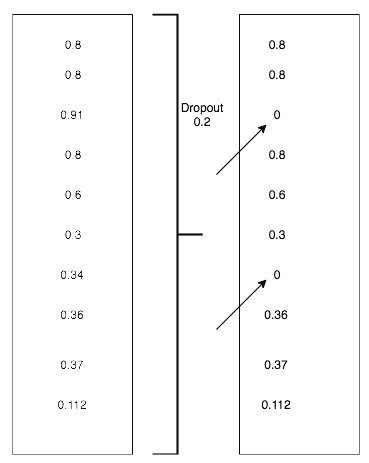

- **Batch normalization**: (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. To increase the stability of a neural network, batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.


In [14]:
class CNN(nn.Module):
  
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)

        self.mp = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.do = nn.Dropout()

        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.mp(self.relu(self.bn1(self.conv1(x))))
        x = self.mp(self.relu(self.bn2(self.conv2(x))))
        x = self.mp(self.relu(self.bn3(self.conv3(x))))
        x = self.mp(self.relu(self.bn4(self.conv4(x))))
        x = self.do(self.mp(self.relu(self.bn5(self.conv5(x)))))

        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        out = self.fc5(x)

        return out

In [15]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (do): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_f

**Calculate the number of trainable parameters (weights and biases)**

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,570,098 trainable parameters


**Optimization Algorithm**

- Steps to optimization

  + Pass a batch of data through your model.
  + Calculate the loss of your batch by comparing your model's predictions against the actual labels.
  + Calculate the gradient of each of your parameters with respect to the loss.
  + Update each of your parameters by subtracting their gradient multiplied by a small learning rate parameter.

In [18]:
optimizer = optim.Adam(model.parameters(), lr=LR)

**Loss Fuction**

- **Cross-entropy** can be used to define a loss function in machine learning and optimization.

In [19]:
loss_fn = nn.CrossEntropyLoss()

**Calculate the accuracy** 
- This takes the index of the highest value for your prediction and compares it against the actual class label. Then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

**Create mini-batch**

In [21]:
def next_batch(X, y, batch_size):
    # Mini-batch
    for i in np.arange(0, X.shape[0], batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

**Transform the model and data to GPU**

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model = model.to(device)
loss_fn = loss_fn.to(device)

### **Training the Model**

**Define Traning step**
- Put the model into train mode: **model.train()**
- Iterate over batches of data.
- Transform the batch to GPU mode.
- Clear the gradients calculated from the last batch.
- Impliment model for batch of images: x, get predictions, y_pred.
- Calculate the loss between prediction labels and the actual labels.
- Calculate the accuracy between prediction labels and the actual labels.
- Calculate the gradients of each parameter.
- Update the parameters by taking optimizer step.
- Return the loss and the accuracy of epoch.

In [24]:
def train(model, X, y, optimizer, loss_fn, device, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment train mode
    model.train()
    
    for (batchX, batchY) in next_batch(X, y, batch_size):
        # SMOTE
        x_tmp = batchX.reshape(batchX.shape[0], 3 * 50 * 50)
        y_tmp = batchY

        count = collections.Counter(y_tmp)

        x_smote, y_smote = SMOTE(sampling_strategy={0: count[0], 1: count[0]}, k_neighbors=3).fit_resample(x_tmp, y_tmp)
        x_smote = x_smote.reshape(x_smote.shape[0], 3, 50, 50)

        # Create tensor
        x = torch.from_numpy(x_smote).to(device)
        y = torch.from_numpy(y_smote).to(device)
        
        # Clear the gradients calculated from the last batch
        optimizer.zero_grad()
                
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        
        # Calculate the gradients of each parameter
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Define Evaluation step**

- Similar the training step. The differences are:
  + Put the model into evalution mode: **model.eval()**
  + Don't calculate the gradients of each parameter.
  + Don't update the parameters by taking optimizer step.

- **torch.no_grad()** ensures that gradients are not calculated for whatever is inside the with block. As our model will not have to calculate gradients it will be faster and use less memory.

In [25]:
def evaluate(model, X, y, loss_fn, device, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment evaluation mode
    model.eval()
    
    with torch.no_grad():
        for (batchX, batchY) in next_batch(X, y, batch_size):
            x = torch.from_numpy(batchX).to(device)
            y = torch.from_numpy(batchY).to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Calculate the time need to run each epoch**

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training the Model**
- Iterate over epochs.
- In each epochs:
  - Training the Model with training set.
  - Evaluate the Model with validation set.
  - Check the best validation loss and save the model parameters
  - Print the result metrics: Loss and Accuracy.

In [27]:
best_valid_loss = float('inf')
train_loss_list = list()
valid_loss_list = list()

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, X_train, y_train, optimizer, loss_fn, device, batch_size=BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, X_valid, y_valid, loss_fn, device, batch_size=BATCH_SIZE)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'smote_v1.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 14s
	Train Loss: 0.468 | Train Acc: 78.58%
	 Val. Loss: 0.402 |  Val. Acc: 82.54%
Epoch: 02 | Epoch Time: 1m 14s
	Train Loss: 0.342 | Train Acc: 85.48%
	 Val. Loss: 0.387 |  Val. Acc: 83.09%
Epoch: 03 | Epoch Time: 1m 14s
	Train Loss: 0.326 | Train Acc: 86.11%
	 Val. Loss: 0.381 |  Val. Acc: 83.52%
Epoch: 04 | Epoch Time: 1m 14s
	Train Loss: 0.315 | Train Acc: 86.61%
	 Val. Loss: 0.366 |  Val. Acc: 84.15%
Epoch: 05 | Epoch Time: 1m 14s
	Train Loss: 0.308 | Train Acc: 87.01%
	 Val. Loss: 0.363 |  Val. Acc: 84.38%
Epoch: 06 | Epoch Time: 1m 14s
	Train Loss: 0.302 | Train Acc: 87.29%
	 Val. Loss: 0.358 |  Val. Acc: 84.60%
Epoch: 07 | Epoch Time: 1m 14s
	Train Loss: 0.297 | Train Acc: 87.56%
	 Val. Loss: 0.357 |  Val. Acc: 84.68%
Epoch: 08 | Epoch Time: 1m 14s
	Train Loss: 0.294 | Train Acc: 87.69%
	 Val. Loss: 0.353 |  Val. Acc: 84.87%
Epoch: 09 | Epoch Time: 1m 14s
	Train Loss: 0.291 | Train Acc: 87.84%
	 Val. Loss: 0.347 |  Val. Acc: 85.14%
Epoch: 10 | Epoch T

**Load the parameters of the best model**

In [28]:
model.load_state_dict(torch.load('smote_v1.pt'))

<All keys matched successfully>

### **Examining the Model**

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

**Visualizing loss of train set and valid set**

In [30]:
epoch_list = np.arange(1, EPOCHS + 1)

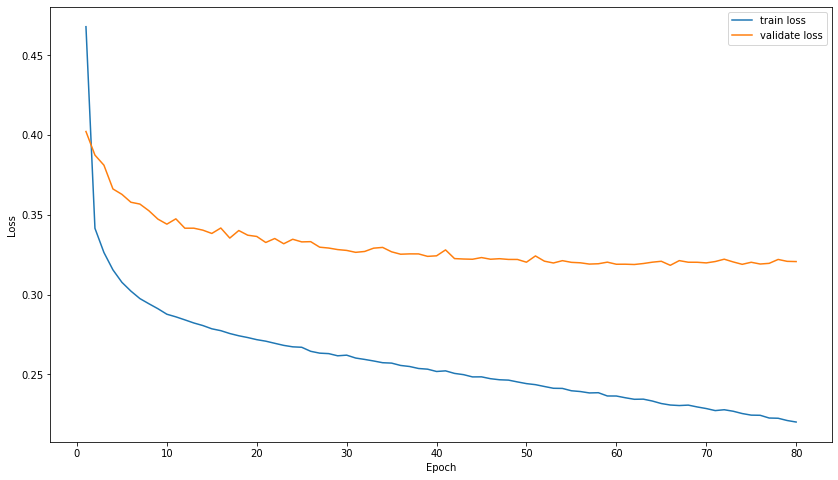

In [31]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(epoch_list, train_loss_list, label='train loss')
ax.plot(epoch_list, valid_loss_list, label='validate loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()
plt.show()

**Get the predictions**

In [32]:
def get_predictions(model, X, y, device, batch_size):
    
    model.eval()
    y_predict = []

    with torch.no_grad():
        for (batchX, batchY) in next_batch(X, y, batch_size):
            X = torch.from_numpy(batchX).to(device)

            y_tmp = model(X)
            top_pred = y_tmp.argmax(1, keepdim = True)

            for i in top_pred:
                y_predict.append(i.item())

    return np.array(y_predict)

In [33]:
y_predict = get_predictions(model, X_test, y_test, device, batch_size=BATCH_SIZE)

**Confusion matrix**

In [34]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[35582  3846]
 [ 3393 12224]]


In [35]:
pd_cm = pd.DataFrame(cm, index = ['negative', 'positive'], columns = ['negative', 'positive'])

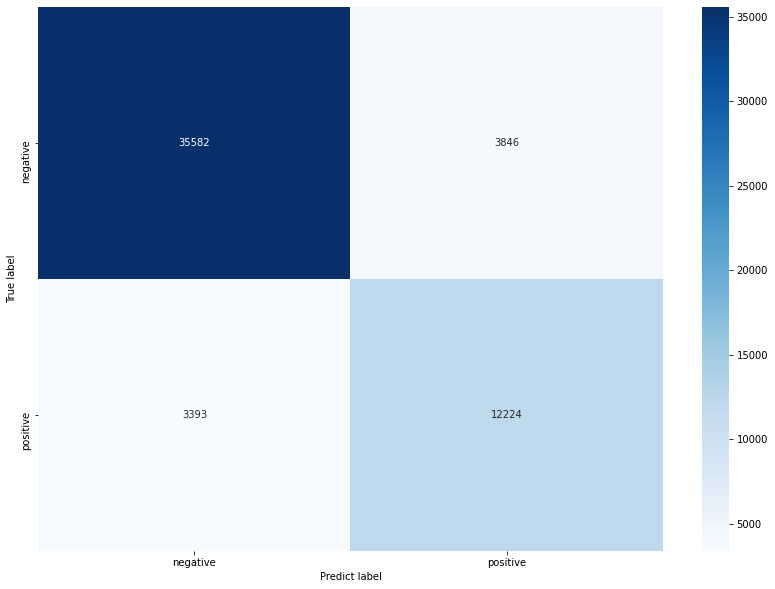

In [36]:
plt.figure(figsize=(14,10))
ax = plt.axes()
sn.heatmap(pd_cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')

plt.show()

**Quantifying the quality of predictions**

In [37]:
def show_metrics_scores(y_test, y_predict):
    print(f'Accuracy score\t\t: {accuracy_score(y_test, y_predict):.4f}\n')
    print(f'Balanced accuracy score\t: {balanced_accuracy_score(y_test, y_predict):.4f}\n')
    print(f'F1 score\t\t: {f1_score(y_test, y_predict):.4f}\n')
    print(f'Recall score\t\t: {recall_score(y_test, y_predict):.4f}')

In [38]:
show_metrics_scores(y_test, y_predict)

Accuracy score		: 0.8685

Balanced accuracy score	: 0.8426

F1 score		: 0.7715

Recall score		: 0.7827
